# Etude des images

In [2]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import re

import fonctions_text_pict as fct

from PIL import Image
from IPython.display import Image as simg

import cv2 as cv

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn import  manifold
from sklearn.pipeline import make_pipeline 
import sklearn.metrics as metrics
from sklearn.preprocessing import Normalizer
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model
from keras import backend as K

from keras.models import load_model
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D


## 0 Preliminaires

Creation du dataframe des images en gardant la meme indexation que pour le texte

In [3]:
df = pd.read_csv("C:/Users/leila/openclassrooms/projet6/flipkart_com-ecommerce_sample_1050.csv",
                sep=',',
                index_col='uniq_id')

In [4]:
# collect categories
df['product_category_tree'] = df['product_category_tree'].apply(
    lambda x: re.split(' >>', x[2:]))
df['category'] = df['product_category_tree'].apply(lambda x: x[0])

# prepare dataframe of pictures
df_pict = df[['product_name','category']].copy()
df_pict.index = [iden + '.jpg' for iden in df_pict.index]
df_pict.head()

product_name  \
55b85ea15a1536d46b7190ad6fff8ce7.jpg  Elegance Polyester Multicolor Abstract Eyelet ...   
7b72c92c2f6c40268628ec5f14c6d590.jpg                         Sathiyas Cotton Bath Towel   
64d5d4a258243731dc7bbb1eef49ad74.jpg                Eurospa Cotton Terry Face Towel Set   
d4684dcdc759dd9cdf41504698d737d8.jpg  SANTOSH ROYAL FASHION Cotton Printed King size...   
6325b6870c54cd47be6ebfbffa620ec7.jpg  Jaipur Print Cotton Floral King sized Double B...   

                                             category  
55b85ea15a1536d46b7190ad6fff8ce7.jpg  Home Furnishing  
7b72c92c2f6c40268628ec5f14c6d590.jpg        Baby Care  
64d5d4a258243731dc7bbb1eef49ad74.jpg        Baby Care  
d4684dcdc759dd9cdf41504698d737d8.jpg  Home Furnishing  
6325b6870c54cd47be6ebfbffa620ec7.jpg  Home Furnishing

In [5]:
Image.MAX_IMAGE_PIXELS = 100000000
# import pictures
file_path = "C:/Users/leila/openclassrooms/projet6/Images/"
l_files = df_pict.index
dict_img = {}
for k, ind in enumerate(l_files,1):
    print('\r', f"{k}/{len(list(l_files))}", end="")
    #transform each picture to a np.array
    img = np.array(Image.open(file_path + ind))
    dict_img[ind] = img

 1050/1050

In [6]:
#replace some terms of categories
df_pict['category'] = df_pict['category'].replace({'Home Furnishing' : 'Furnishing',
                                         'Baby Care' : 'Baby',
                                         'Home Decor & Festive Needs' : 'Decor',
                                         'Kitchen & Dining' :'Kitchen',
                                         'Beauty and Personal Care' : 'Beauty'})

In [7]:
 df_pict = pd.concat([df_pict, pd.Series(dict_img,
                                           index = df_pict.index,
                                       name='img').to_frame()],
                                          axis=1)
df_pict.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1050 entries, 55b85ea15a1536d46b7190ad6fff8ce7.jpg to f2f027ad6a6df617c9f125173da71e44.jpg
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   product_name  1050 non-null   object
 1   category      1050 non-null   object
 2   img           1050 non-null   object
dtypes: object(3)
memory usage: 32.8+ KB


Regardons quelques images par categorie

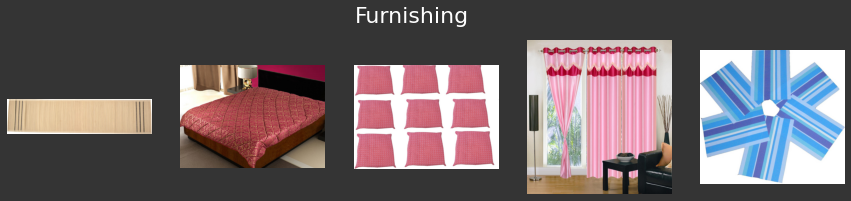

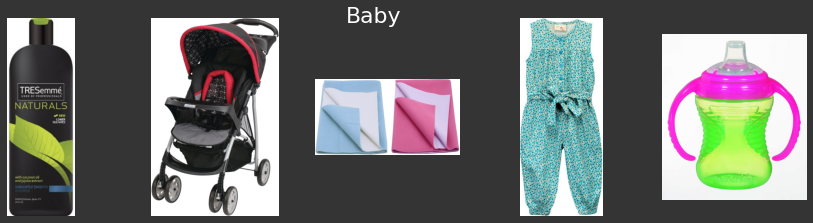

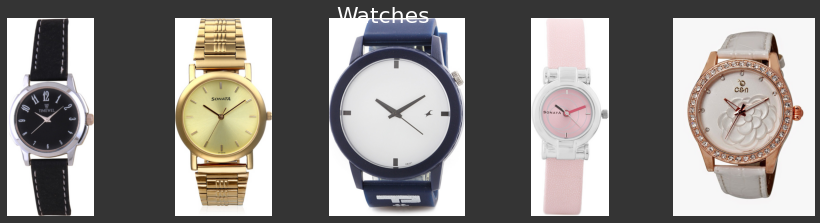

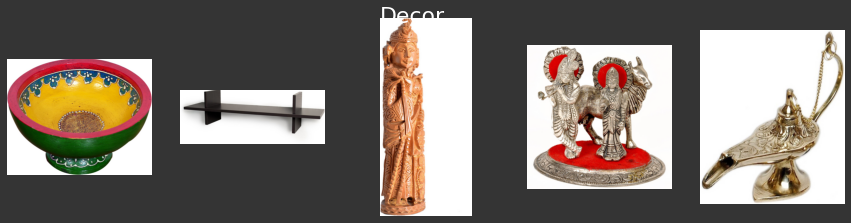

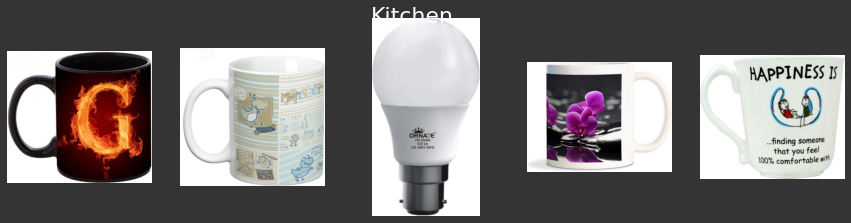

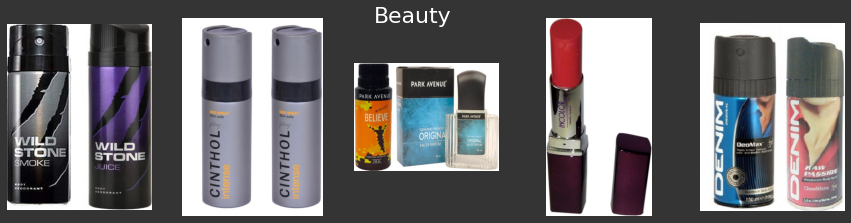

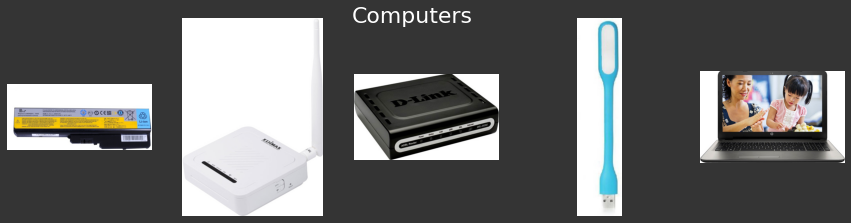

In [8]:
cat = list(df_pict['category'].unique())
for c in cat:
    fct.show_images_cat(df_pict[df_pict['category']==c], c, 5)

## 1 Preprocessing 

Nous allons regarder chaque procede sur une image test. 

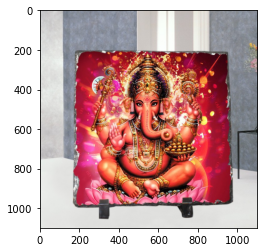

In [9]:
img_test = cv.imread(file_path + 'fd75569f00649bda69d490d54e01378c.jpg')
fig = plt.figure(figsize=(4,4))
plt.imshow(img_test[:,:,::-1])

**1.1. Modification de la taille des images**

Nous allons devoir modifier la taille des images pour qu'elles s'adaptent aux contraintes du modèle CNN de transfert learning. 

Redimensionner les images ne va pas changer leurs attributs, l'image va même être déformée pour coller au nouvelles dimensions.


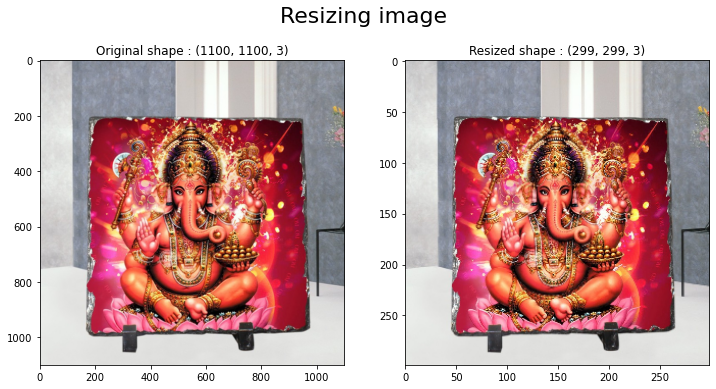

In [10]:
height = 299
width = 299
dim = (width, height)
# resize image with OpenCV
res_img = cv.resize(img_test, dim, interpolation=cv.INTER_LINEAR)

# Show both img
fig = plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.imshow(img_test[:,:,::-1])
plt.title("Original shape : {}".format(img_test.shape))
plt.subplot(1, 2, 2)
plt.imshow(res_img[:,:,::-1])
plt.title("Resized shape : {}".format(res_img.shape))
plt.suptitle("Resizing image",
             color="black", 
             fontsize=22, y=.98)
plt.show()

L'image n'est pas deformee car elle etait deja dans une forme carree. Ce ne sera pas toujours le cas, donc on aura un certain nombre d'images deformees apres redimensionnement.  

**1.2 Egalisation des images**

L'histogramme d'une image numerique est une courbe statistique representant la repartition de ses pixels selon leur intensite. Commençons par regarder une image en particulier.

Nous allons transformer l'image dans differents codages couleurs. Le systeme de codage YUV est cree depuis une source RVB. Il est code en trois composantes : Y represente la luminance (informations de luminosite) tandis que les deux autres (U et V) sont des donnees de chrominance (informations de couleur). Ce format nous permet de visualiser au mieux l'histogramme pour les 3 dimensions :

In [11]:
# Transform image with differents color sets
img_RGB = cv.cvtColor(img_test, cv.COLOR_BGR2RGB)
img_grayscale = cv.cvtColor(img_test, cv.COLOR_BGR2GRAY)
img_YUV = cv.cvtColor(img_test,cv.COLOR_BGR2YUV)

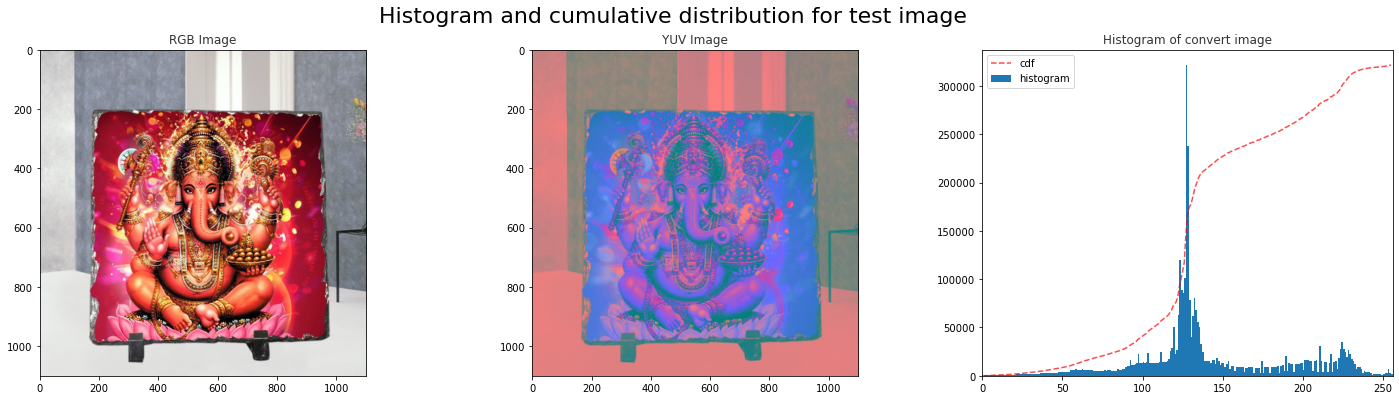

In [12]:
fct.plot_histogram(["RGB", img_RGB], ["YUV", img_YUV])

**Egalisation**

On constate ici des pics importants au centre de l'histogram. Dans le cadre d'une bonne egalisation (amelioration du contraste), il est necessaire de repartir la lumiere dans tout le spectre de l'image.

Testons l'egalisation avec OpenCV :
l'interet de convertir l'image dans l'espace colorimetrique YUV est de pouvoir agir sur le canal "luminance" (Y) independamment des autres canaux de chrominance. Nous allons donc realiser l'egalisation sur ce seul canal Y :


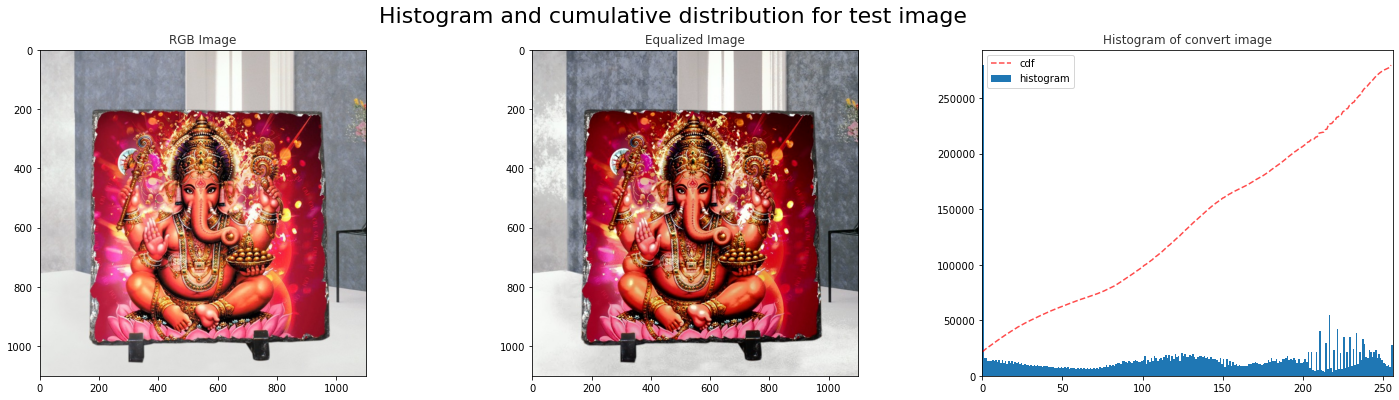

In [14]:
# Equalization
img_YUV[:,:,0] = cv.equalizeHist(img_YUV[:,:,0])
img_equ = cv.cvtColor(img_YUV, cv.COLOR_YUV2RGB)
fct.plot_histogram(["RGB", img_RGB], ["Equalized", img_equ])

L'image resultante est donc bien egalisee, l'histogramme couvre l'ensemble du spectre et la CDF est presque constante et linéaire.

**1.3 Application de filtres**

Les images peuvent pour de nombreuses raisons etre bruitees, c'est à dire comporter des pixels atypiques qui peuvent fausser la detection de features. Exemple de causes de bruits :

- Caractéristiques de l'appareil photo,
- Compression des images JPEG
- Mauvaise résolution ...

Pour pallier au bruit present dans les images, il est possible d'appliquer un filtre. Il en existe de plusieurs types : les filtres lineaires (comme le filtre Gaussien), non lineaires comme le filtre median par exemple.
Un des meilleurs filtre pour debruiter l'image est le filtre non-local means.

Filtre non-local means  
Contrairement aux filtres « moyenne locale », qui prennent la valeur moyenne d'un groupe de pixels entourant un pixel cible pour lisser l'image, le filtrage des moyennes non locales prend une moyenne ponderee de tous les pixels des fenetres similaires a la fenetre cible. Cela se traduit par une clarte de post-filtrage beaucoup plus grande et moins de perte de details dans l'image par rapport aux algorithmes de moyenne locale.

Testons ce fitre sur notre image test :

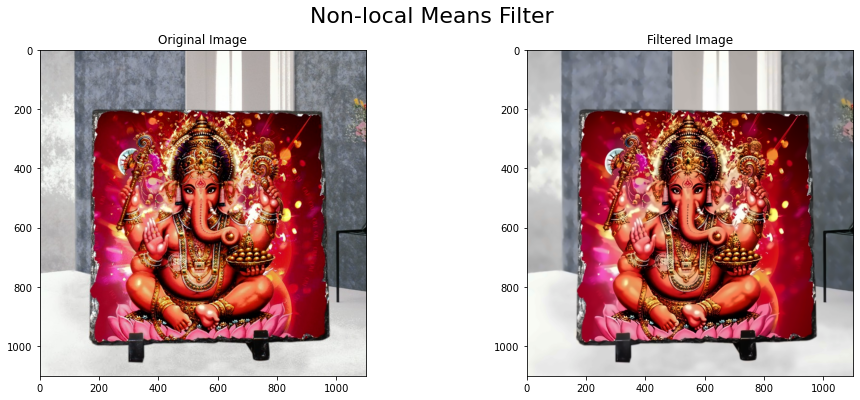

In [15]:
# Apply non-local means filter on test img
dst_img = cv.fastNlMeansDenoisingColored(
    src=img_equ,
    dst=None,
    h=10,
    hColor=10,
    templateWindowSize=7,
    searchWindowSize=21)

# Show both img
fig = plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
plt.imshow(img_equ)
plt.title("Original Image")
plt.subplot(1, 2, 2)
plt.imshow(dst_img)
plt.title("Filtered Image")
plt.suptitle("Non-local Means Filter",
             color="black", 
             fontsize=22, y=.98)
plt.show()

**1.4 Prepocessing pour toutes les images**

Nous allons creer des colonnes dans df_pict qui correspondent aux transformations des images

In [16]:
# to gray
def gray(img):
    return cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# choice of dimension
def resizing(img) :
    dim = (224, 224)
    return cv.resize(img, dim, interpolation=cv.INTER_LINEAR)

# equalization
def equ_color(img):
    img_cyuv = cv.cvtColor(img, cv.COLOR_BGR2YUV)
    img_cyuv[:,:,0] = cv.equalizeHist(img_cyuv[:,:,0])
    img_cequ = cv.cvtColor(img_cyuv, cv.COLOR_YUV2RGB)
    return img_cequ

def equ_gray(img):
    img_gequ = cv.equalizeHist(img)
    return img_gequ

# preprocess
def preprocessing(image):
    """Preprocessing of images. Equalization, 
    Denoising and transformation of the image into Array. 

    Args :
    image : name of image
    img_width : integer
        width of the image to be reached for resizing
    img_height : integer
        height of the image to be reached for resizing
    color : boolean
        True for RGB, False for gray
    """
    img_t = image
    img_t = resizing(img_t)
    img_gt = gray(img_t)
    img_cte = equ_color(img_t)
    img_gte = equ_gray(img_gt)
    # Apply non-local means filter on test img
    dst_imgc = cv.fastNlMeansDenoisingColored(
                src=img_cte,
                dst=None,
                h=10,
                hColor=10,
                templateWindowSize=7,
                searchWindowSize=21)
    
    dst_imgg = cv.fastNlMeansDenoising(
                src=img_gte,
                dst=None,
                h=10,
                templateWindowSize=7,
                searchWindowSize=21)   
            
    return  dst_imgc,dst_imgg

In [18]:
# application et store dans le dataframe
dictc_transf = {}
dictg_transf = {}
for k, ind in enumerate(df_pict.index, 1):
    dictc_transf[ind],dictg_transf[ind] = preprocessing(df_pict['img'].loc[ind])
            
seriec_pict = pd.Series(dictc_transf)
df_pict['img_color_t'] = seriec_pict.to_frame()
serieg_pict = pd.Series(dictg_transf)
df_pict['img_gray_t'] = serieg_pict.to_frame()        

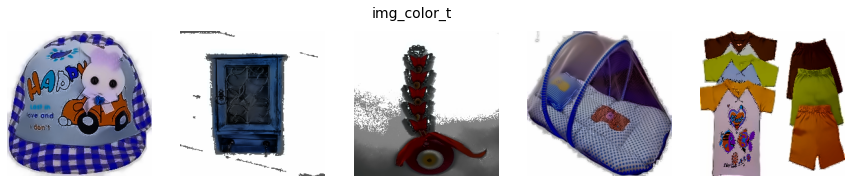

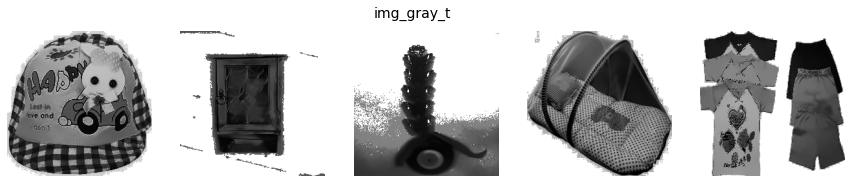

In [19]:
#visualisations
fig = plt.figure(figsize=(15,3))
plt.suptitle('img_color_t', y=.95, fontsize=14)
tc = df_pict['img_color_t']
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(tc[i+79])
    plt.axis('off')
plt.show()
fig = plt.figure(figsize=(15,3))
plt.suptitle('img_gray_t', y=.95, fontsize=14)
tg = df_pict['img_gray_t']
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(tg[i+79], cmap='gray', vmin=0, vmax=255)
    plt.axis('off')
plt.show()


## 2 Clustering

Bag Of Visual Words est une technique permettant de décrire de maniere compacte des images et de calculer les similitudes entre les images. Dans BoVW, nous decomposons notre image en un ensemble de fonctionnalites independantes. Les fonctionnalites consistent en des points cles et des descripteurs. Les points cles sont la meme chose que les points d'interet. Sur la base de ces descripteurs en utilisant des algorithmes de clustering, nous reiterons a travers nos images et verifions si notre image contient des mots dans le dictionnaire. Si oui, nous augmentons le nombre de ce mot particulier. Enfin, nous creons l'histogramme de cette image. À partir de cet histogramme, nous pouvons predire la categorie de cette image.

Pour trouver les points cles et les descripteurs nous allons tester deux algorithmes SIFT, ORB

**2.1 SIFT**

Techniques utilisées dans les différentes étapes de SIFT   

|Etape |	Techniques utilisees 	|
|:------|:----------------------------|
|Extraction des points-cles  |	Pyramide de gradients, difference de gaussiens, assignation d’orientation |	
|Calcul des descripteurs | 	Echantillonnage et lissage des plans locaux d’orientation de l’image |	
|Indexation des descripteurs des images  |	Arbre kd 	|
|Recherche des correspondances avec les descripteurs de l'image question |	Plus proche voisin approximatif (Best Bin First)| 
|Identification de clusters 	|Transformee de Hough et table de hachage |	
|Verification du modèle |	Moindres carres lineaires |	
|Validation de l'hypothese |	Inference bayesienne |

Commencons par tester sur une image

In [20]:
def gen_sift_features(gray_img):
    sift = cv.SIFT_create()
    kp, desc = sift.detectAndCompute(gray_img, None)
    return kp, desc
    
def show_features(img, kp):
    # draw keypoints
    flags = cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    test = cv.drawKeypoints(img, kp, None, flags=flags) 
    plt.figure(figsize=(5,5))
    plt.imshow(test)
    plt.title("keypoints")
    plt.show()

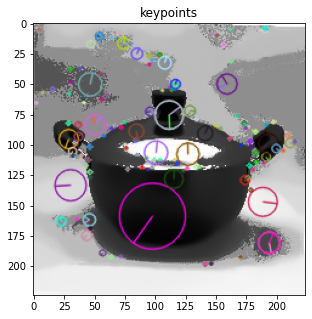

In [22]:
# image test
essai=df_pict['img_gray_t'].loc['2e8df36b35d22cf219cf8bae6c2af752.jpg']
# generate keypoints and descriptors
kp, desc = gen_sift_features(essai)
show_features(essai, kp)

Fonctions permettant de recuperer les key_points et les descriptors via sift pour toutes les images

In [23]:
def extract_sift_features(serie_images, nfeatures=1000):
    '''Creates descriptors using sift 
    Args :
    serie_images : pd.Series of images (one image is a np.array)
    Returns :
    pd.Series of all the descriptors of each image (for each image a np.array of 128 vectors)
    and a list of all the descriptors
    '''  
    descriptors = []
    all_descriptors = []
    sift = cv.SIFT_create(nfeatures=nfeatures,
                           nOctaveLayers=3, # default val
                           contrastThreshold=0.04,  # default val
                           edgeThreshold=10,  # default val
                           sigma=1.6)  # default val
    serie_descriptors = pd.Series(dtype=int)
    for i, img in serie_images.iteritems():
        kp, desc = sift.detectAndCompute(img, None)
        desc = [np.zeros((128,))] if desc is None else desc # in case no descriptor
        all_descriptors.extend(list(desc))
        descriptors.append(desc)
    serie_descriptors = pd.Series(descriptors,
                                index=serie_images.index)
    return serie_descriptors, all_descriptors

In [24]:
def select_visual_words(n_visual_words, descriptors_list):
    ''' Apply a k-means clustering 
    Args :
    n_visual_words : int number of clusters = nb groups of descriptors
    descriptors_list : list 
    Returns :
    an array of the centroids (i.e. the visual words).
    '''
    clus = KMeans(n_clusters = n_visual_words,
                       random_state=14)
    clus.fit(pd.DataFrame(descriptors_list))
    visual_words = clus.cluster_centers_ 
    return visual_words, clus

In [25]:
# Compute the descriptors of each image (choose max nb of descriptors per image)
serie_descriptors, all_descriptors = extract_sift_features(df_pict['img_gray_t'],
                                                         nfeatures=20)
print("total nb of descriptors",
      len(all_descriptors))
print("mean nb of descriptors per image: {:.0f}"\
      .format(serie_descriptors.apply(len).mean()))


total nb of descriptors 21214
mean nb of descriptors per image: 20


In [27]:
visual_words, vw_predictor = select_visual_words(20, all_descriptors)
visual_words.shape

(20, 128)

In [28]:
# Gives for each descriptor of each image the label of the nearest visual word
# and builds the list of the visual words in one image
# Does this through all the images.
vw_list = []
ind_img_list = []
# loop on the items :
for n_img, desc_list in serie_descriptors.iteritems(): 
    vwords = vw_predictor.predict(desc_list) # list of the vw labels in each image
    vw_list.append(vwords) # generate a list of vw labels lists

In [29]:
print("exemple of the visual words in the 1st image: ",vw_list[0])

exemple of the visual words in the 1st image:  [10 12 19 15 19  3 10  3 17 18 18 10 10  9  9  2 16  9 12  9  9]


In [30]:
# create BovW
df_BovW = pd.DataFrame([Counter(x) for x in vw_list],
                               index = serie_descriptors.index).fillna(0)
df_BovW = df_BovW[sorted(df_BovW.columns)]

In [31]:
df_BovW.head()

0    1    2    3    4    5    6    7   \
55b85ea15a1536d46b7190ad6fff8ce7.jpg  0.0  0.0  1.0  2.0  0.0  0.0  0.0  0.0   
7b72c92c2f6c40268628ec5f14c6d590.jpg  5.0  0.0  0.0  0.0  0.0  2.0  0.0  1.0   
64d5d4a258243731dc7bbb1eef49ad74.jpg  0.0  0.0  1.0  1.0  0.0  3.0  0.0  0.0   
d4684dcdc759dd9cdf41504698d737d8.jpg  3.0  1.0  1.0  0.0  0.0  3.0  0.0  1.0   
6325b6870c54cd47be6ebfbffa620ec7.jpg  0.0  2.0  2.0  3.0  0.0  2.0  2.0  0.0   

                                       8    9    10   11   12   13   14   15  \
55b85ea15a1536d46b7190ad6fff8ce7.jpg  0.0  5.0  4.0  0.0  2.0  0.0  0.0  1.0   
7b72c92c2f6c40268628ec5f14c6d590.jpg  3.0  0.0  1.0  3.0  1.0  1.0  1.0  1.0   
64d5d4a258243731dc7bbb1eef49ad74.jpg  0.0  4.0  0.0  1.0  1.0  0.0  4.0  2.0   
d4684dcdc759dd9cdf41504698d737d8.jpg  1.0  0.0  3.0  0.0  0.0  0.0  5.0  2.0   
6325b6870c54cd47be6ebfbffa620ec7.jpg  0.0  0.0  1.0  0.0  0.0  0.0  2.0  5.0   

                                       16   17   18   19  
55b85ea15a1536d46b7190ad6fff8ce7.jpg  1.0  1.0  2.0  2.0  
7b72c92c2f6c40268628ec5f14c6d590.jpg  0.0  0.0  0.0  1.0  
64d5d4a258243731dc7bbb1eef49ad74.jpg  1.0  0.0  0.0  2.0  
d4684dcdc759dd9cdf41504698d737d8.jpg  0.0  0.0  0.0  0.0  
6325b6870c54cd47be6ebfbffa620ec7.jpg  0.0  0.0  0.0  1.0

Utilisation de Kmeans pour tenter de determiner les categories a partir du BovW trouve

In [36]:
X = df_BovW
km = KMeans(n_clusters=7) 
# Fitting the Kmeans model
km.fit(X)
y_pred = km.labels_

metrics.adjusted_rand_score(serie_results, df_pict['category'])

0.014042570477913071

Le resultat est deplorable.  
Visualisons les predictions via tSNE

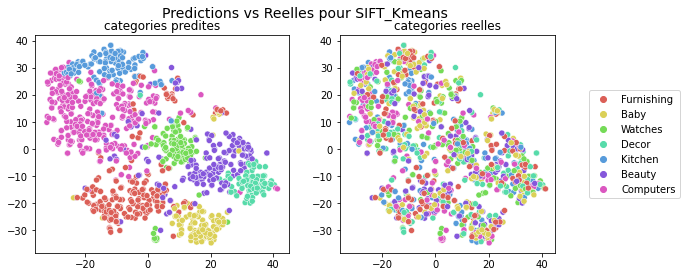

In [47]:
colors1 = list(df_pict['category'].unique())
num_sift_labels = pd.DataFrame(df_pict['category'])
num_sift_labels['y_pred'] = y_pred
sift_labels = fct.categ_identificator(num_sift_labels, true_cat=None)
fct.plot_TSNE(X_normal,sift_labels['y_pred'].values,
             df_pict['category'].values, colors1, 'SIFT_Kmeans')


On constate visuellement que les categories predites ne sont pas bonnes. SiFT ne semble pas efficace dans notre cas.

**2.2 ORB**

L'algorithme orb utilise une pyramide d'images à plusieurs echelles. Une pyramide d'images est une representation multi-echelles d'une seule image, constituee de séquences d'images qui sont toutes des versions de l'image à differentes resolutions. Chaque niveau de la pyramide contient la version sous-echantillonnee de l'image par rapport au niveau precedent. Une fois qu'ORB a cree une pyramide, il utilise l'algorithme FAST pour détecter les points cles dans l'image. En detectant les points cles à chaque niveau, ORB localise efficacement les points cles à une echelle differente. 
Pour les descripteurs ORB utilise BRIEF en l'ameliorant pour le rendre insensible aux rotations

In [48]:
def gen_orb_features(gray_img):
    orb = cv.ORB_create()
    kp, desc = orb.detectAndCompute(gray_img, None)
    return kp, desc
    

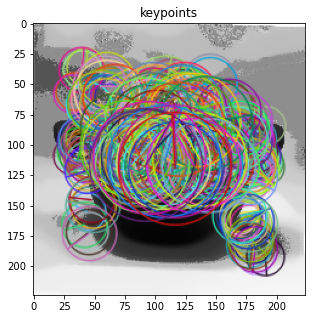

In [49]:
# image test
essai=df_pict['img_gray_t'].loc['2e8df36b35d22cf219cf8bae6c2af752.jpg']
# generate keypoints and descriptors
kps, descs = gen_orb_features(essai)
show_features(essai, kps)

Traitement de toutes les images

In [50]:
def extract_orb_features(serie_images):
    '''Creates descriptors using sift 
    Args :
    serie_images : pd.Series of images (one image is a np.array)
    Returns :
    pd.Series of all the descriptors of each image (for each image a np.array of 128 vectors)
    and a list of all the descriptors
    '''  
    descriptors = []
    all_descriptors = []
    orb = cv.ORB_create()  
    serie_descriptors = pd.Series(dtype=int)
    for i, img in serie_images.iteritems():
        kp, desc = orb.detectAndCompute(img, None)
        desc = [np.zeros((128,))] if desc is None else desc # in case no descriptor
        all_descriptors.extend(list(desc))
        descriptors.append(desc)
    serie_descriptors = pd.Series(descriptors,
                                index=serie_images.index)
    return serie_descriptors, all_descriptors

In [51]:
serie_descriptors_orb, all_descriptors_orb = extract_orb_features(df_pict['img_gray_t'])
print("total nb of descriptors",
      len(all_descriptors_orb))
print("mean nb of descriptors per image: {:.0f}"\
      .format(serie_descriptors_orb.apply(len).mean()))

total nb of descriptors 381459
mean nb of descriptors per image: 363


In [52]:
visual_words_orb, vw_predictor_orb = select_visual_words(363, all_descriptors_orb)


In [53]:
vwo_list = []
# loop on the items :
for n_img, desc_list in serie_descriptors_orb.iteritems(): 
    vwords = vw_predictor_orb.predict(desc_list) 
    vwo_list.append(vwords)

df_BovWo = pd.DataFrame([Counter(x) for x in vwo_list],
                               index = serie_descriptors_orb.index).fillna(0)
df_BovWo = df_BovWo[sorted(df_BovWo.columns)]

In [58]:
Xo = df_BovWo

kmeans = KMeans(n_clusters=7, init='k-means++').fit(Xo)
y_predo = kmeans.labels_
metrics.adjusted_rand_score(y_predo, df_pict['category'])


0.025346300155197905

La encore le score ARI est tres mauvais. 

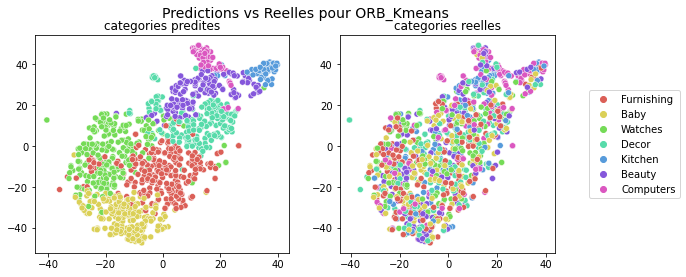

In [59]:
num_orb_labels = pd.DataFrame(df_pict['category'])
num_orb_labels['y_predo'] = y_predo
orb_labels = fct.categ_identificator(num_orb_labels, true_cat=None)
fct.plot_TSNE(Xo, orb_labels['y_predo'].values,
             df_pict['category'].values, colors1, 'ORB_Kmeans')

On retrouve le meme probleme qu'avec SIFT

## 3 Transfert learning

Nous allons utiliser 2 algos pre-entraine : VGG-16 et ResNet50. L'execution a ete faite sur colab.
l'objectif etent de recuperer les features des modeles, nous avons remplace la derniere couche par GlobalMaxPooling2D()  
L'idée est de générer une carte de caractéristiques pour chaque catégorie correspondante de la tâche de classification dans la dernière couche mlpconv. Au lieu d’ajouter des couches entièrement connectées au-dessus des cartes de caractéristiques, nous prenons la moyenne de chaque carte de caractéristiques et le vecteur résultant est celui des features que l'on cherche

In [60]:
def extract_feature(model):
    cnn_model = cnn_model = Sequential()
    cnn_model.add(model)
    # add layer for dimensional reduction (global max pooling) 
    cnn_model.add(GlobalMaxPooling2D())
    features = []
    for img in df_pict['img_color']:
        # reshape img (np.array) to get a tensor
        img = img.reshape(1, img.shape[0], img.shape[1], img.shape[2])

        # preprocess images
        img = imagenet_utils.preprocess_input(img, data_format=None, mode='caffe')
    
        # get the extracted features
        features.append(cnn_model.predict(img).reshape(-1))
    
    return pd.Series(features,
                     index=df_pict.index)

In [61]:
# models
vgg = VGG16(weights="imagenet",
            include_top=False,
            input_shape=(224, 224, 3))
resnet = ResNet50(weights='imagenet',
                           include_top=False, 
                           input_shape=(224,224,3))


In [62]:
# read results
X_vgg = pd.read_csv("C:/Users/leila/openclassrooms/projet6/X_df.csv",sep=',',
                index_col=0)
X_res = pd.read_csv("C:/Users/leila/openclassrooms/projet6/Xres_df.csv",sep=',',
                index_col=0)

In [63]:
X_vgg.head()

0          1          2  \
55b85ea15a1536d46b7190ad6fff8ce7.jpg    0.000000  29.185051   0.000000   
7b72c92c2f6c40268628ec5f14c6d590.jpg    0.000000   0.000000   0.000000   
64d5d4a258243731dc7bbb1eef49ad74.jpg    0.000000   1.498687   0.000000   
d4684dcdc759dd9cdf41504698d737d8.jpg  105.053795   1.037664  21.818285   
6325b6870c54cd47be6ebfbffa620ec7.jpg   19.924904   0.000000   4.754766   

                                              3          4          5  \
55b85ea15a1536d46b7190ad6fff8ce7.jpg   0.000000  18.353838  18.575836   
7b72c92c2f6c40268628ec5f14c6d590.jpg   0.000000   0.000000   2.008694   
64d5d4a258243731dc7bbb1eef49ad74.jpg   0.000000  19.150978   0.000000   
d4684dcdc759dd9cdf41504698d737d8.jpg  17.115097   0.000000  18.139687   
6325b6870c54cd47be6ebfbffa620ec7.jpg   0.000000  22.874400   0.000000   

                                               6          7    8          9  \
55b85ea15a1536d46b7190ad6fff8ce7.jpg   52.882366   0.000000  0.0  18.681726   
7b72c92c2f6c40268628ec5f14c6d590.jpg    0.000000   0.000000  0.0  71.060425   
64d5d4a258243731dc7bbb1eef49ad74.jpg  136.606140   0.000000  0.0  24.267956   
d4684dcdc759dd9cdf41504698d737d8.jpg   15.269767  45.223610  0.0  36.966780   
6325b6870c54cd47be6ebfbffa620ec7.jpg   36.612835  18.815645  0.0   2.768113   

                                      ...         502         503       504  \
55b85ea15a1536d46b7190ad6fff8ce7.jpg  ...    0.000000   90.718150  13.94031   
7b72c92c2f6c40268628ec5f14c6d590.jpg  ...  151.076600   40.234127   0.00000   
64d5d4a258243731dc7bbb1eef49ad74.jpg  ...    3.091991   86.732450  34.63045   
d4684dcdc759dd9cdf41504698d737d8.jpg  ...   54.962307   70.267586   0.00000   
6325b6870c54cd47be6ebfbffa620ec7.jpg  ...   50.175340  204.904300   0.00000   

                                             505        506        507  \
55b85ea15a1536d46b7190ad6fff8ce7.jpg  105.966125   57.70118  53.309166   
7b72c92c2f6c40268628ec5f14c6d590.jpg  188.267610   93.05661  32.381516   
64d5d4a258243731dc7bbb1eef49ad74.jpg   64.473400  193.37202  19.166595   
d4684dcdc759dd9cdf41504698d737d8.jpg   82.860580   78.53095  64.597820   
6325b6870c54cd47be6ebfbffa620ec7.jpg   52.260975   80.30503  52.634810   

                                             508        509        510  \
55b85ea15a1536d46b7190ad6fff8ce7.jpg   39.591130   5.860785  16.491010   
7b72c92c2f6c40268628ec5f14c6d590.jpg  202.641070  21.124708  32.551500   
64d5d4a258243731dc7bbb1eef49ad74.jpg   78.342926   5.824037   4.094481   
d4684dcdc759dd9cdf41504698d737d8.jpg  163.355010   4.873663  66.071360   
6325b6870c54cd47be6ebfbffa620ec7.jpg  118.767110  28.311708  64.757935   

                                          511  
55b85ea15a1536d46b7190ad6fff8ce7.jpg  0.00000  
7b72c92c2f6c40268628ec5f14c6d590.jpg  0.00000  
64d5d4a258243731dc7bbb1eef49ad74.jpg  0.00000  
d4684dcdc759dd9cdf41504698d737d8.jpg  0.00000  
6325b6870c54cd47be6ebfbffa620ec7.jpg  5.48488  

[5 rows x 512 columns]

In [64]:
from umap import UMAP

Reduction de dimension a l'aide de UMAP. Apres avoir teste plusieurs parametres, il est apparu que les meilleurs scores ARI sont obtenus pour ceux choisis

In [65]:
umap = UMAP(min_dist=0.2, n_neighbors=100)
Xvp = umap.fit_transform(X_vgg)

In [66]:
# clustering pour X_vgg projete
kmeans = KMeans(n_clusters=7, init='k-means++').fit(Xvp)
y_predv = kmeans.labels_
metrics.adjusted_rand_score(y_predv, df_pict['category'])


0.38524894204649596

Nous faisons la meme chose pour ResNet50

In [68]:
umap = UMAP(min_dist=0.2, n_neighbors=100)
Xresp = umap.fit_transform(X_res)


In [69]:
kmeans = KMeans(n_clusters=7, init='k-means++').fit(Xresp)
y_predrp = kmeans.labels_
metrics.adjusted_rand_score(y_predrp, df_pict['category'])

0.48446901431848344

Nous constatons une nette amelioration des scores ARI. Le model ResNet50 donne les meilleurs resultats pour KMeans.  
Transformations des labels predits en categories correspondantes pour VGG-16 et ResNet50

In [70]:
df_labels = pd.DataFrame(df_pict['category'])
df_labels['cat_vgg'] = y_predv
df_labels['cat_res'] = y_predrp
df_labels.head()

category  cat_vgg  cat_res
55b85ea15a1536d46b7190ad6fff8ce7.jpg  Furnishing        0        4
7b72c92c2f6c40268628ec5f14c6d590.jpg        Baby        0        4
64d5d4a258243731dc7bbb1eef49ad74.jpg        Baby        3        4
d4684dcdc759dd9cdf41504698d737d8.jpg  Furnishing        3        4
6325b6870c54cd47be6ebfbffa620ec7.jpg  Furnishing        0        4

In [71]:
cat_result = fct.categ_identificator(df_labels, true_cat=None)

In [72]:
cat_result.head()

category     cat_vgg     cat_res
55b85ea15a1536d46b7190ad6fff8ce7.jpg  Furnishing  Furnishing  Furnishing
7b72c92c2f6c40268628ec5f14c6d590.jpg        Baby  Furnishing  Furnishing
64d5d4a258243731dc7bbb1eef49ad74.jpg        Baby        Baby  Furnishing
d4684dcdc759dd9cdf41504698d737d8.jpg  Furnishing        Baby  Furnishing
6325b6870c54cd47be6ebfbffa620ec7.jpg  Furnishing  Furnishing  Furnishing

Visualisations des resultats via tSNE

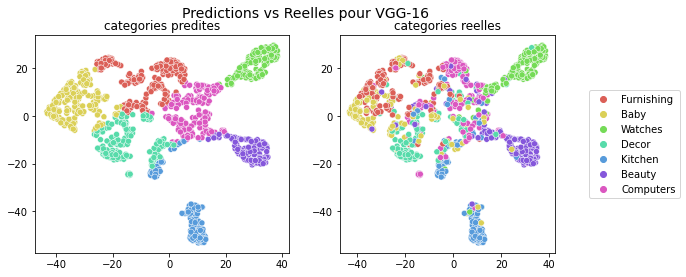

In [74]:
colors1 = list(cat_result['category'].unique())
fct.plot_TSNE(Xvp, cat_result['cat_vgg'].values,
             cat_result['category'].values, colors1, 'VGG-16')

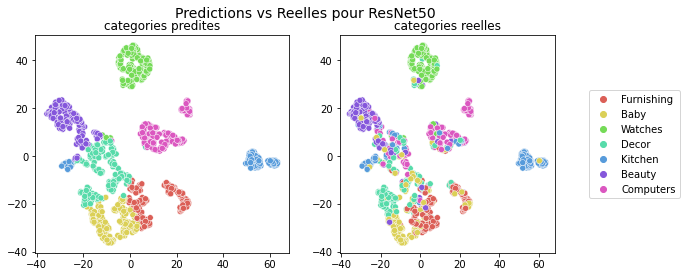

In [79]:
colors1 = list(cat_result['category'].unique())
fct.plot_TSNE(Xresp, cat_result['cat_res'].values,
             cat_result['category'].values, colors1, 'ResNet50')

Les resultats obtenus avec les images semblent meilleurs qu'avec les textes pour la categorie Furnishing. C'est l'inverse par exemple pour la categorie Watches. On va donc regarder si en couplant image et textes, on obtient de meilleurs resultats.

In [80]:
cat_result.to_csv('cat_result.csv')